<a href="https://colab.research.google.com/github/mantoan-thi/Machine-Learning-Projects-with-Python/blob/main/Previs%C3%A3o_de_defeitos_QA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importando as bibliotecas

In [20]:
import pandas as pd
from datetime import date, datetime
import numpy as np
from matplotlib import pyplot
import plotly.express as px
from fbprophet import Prophet
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from fbprophet.plot import plot_plotly, plot_components_plotly

In [138]:
# Carrega a planilha
df = pd.read_excel('/content/Indicadores Internos SAP rev 17A.xlsx',sheet_name='Base de dados')

# Renomear as colunas
df.columns = df.iloc[1]

# Excluir as linhas 0 e 1
for i in range(0,2):
  df.drop(i,inplace=True)

# Retira o index
df.reset_index(drop=True, inplace=True)

# Exclui as linhas que contém: fechamento e 200%
df = df[(df['Processo']!='fechamento') & (df['Processo']!='200%')]

# Retirando as colunas abaixo
df = df[['Data','Turno','Projeto','QTD DEF']]

# Excluir os valores nan
df.dropna(inplace=True)

# Converte as datas
df['Data'] = df['Data'].apply(lambda x: x.strftime('%d/%m/%Y'))

In [139]:
lista_de = ['T9','T9LT novo','TRYX NOVO','360b','833B','TRYX novo','T5NR novo','T9LM NOVO','T5R NOVO','T5RN NOVO','T5NM NOVO','T5NM']
lista_para = ['T9LT','T9LT','TRYX','360B','833W','TRYX','T5NR','T9LT','T5NR','T5NR','T5NR','T5NR']

# Ajustando...
de = 'T9'
para = 'T9LT'
for i in range(0,len(lista_de)):
  df['Projeto'] = df['Projeto'].apply(lambda x: lista_para[i] if x == lista_de[i] else x)

# Extraindo os projetos
lista_proj = list(set(df['Projeto']))

print('Quantidade de projetos: ',len(lista_proj))
lista_proj

Quantidade de projetos:  15


['474B',
 'TRYX',
 'T5/TR',
 'Actros',
 'T5NR',
 'T00A',
 'Mahle',
 'T9LT',
 '360B',
 'VIVA PUP',
 'Kongsberg',
 'kanjiko',
 '833W',
 'T9LM',
 '740B']

In [140]:
# Gráfico...
n_df = df[df['Projeto']=='360B']
fig = px.line(n_df, x='Data', y='QTD DEF', title='Projetos',color='Projeto')
fig.show()

# Plotar gráficos

In [24]:
turnos = ['A','B']
resumo = []

for t in turnos:
  for proj in lista_proj:
    new_df = df[(df['Turno']==t) & (df['Projeto']==proj)]
    resumo.append([proj,t,new_df.shape[0]])

resumo = pd.DataFrame(resumo,columns=['Projeto','Turno','Qtde def'])
resumo.sort_values(by=['Qtde def'], ascending=False,inplace=True)

# Top 10...
resumo.head(10)

,Projeto,Turno,Qtde def
8,360B,A,10491
14,740B,A,9303
23,360B,B,7403
29,740B,B,6566
0,474B,A,2729
2,T5/TR,A,2267
5,T00A,A,2141
7,T9LT,A,1640
1,TRYX,A,1320
15,474B,B,1144


# Funções

In [26]:
def previsao(df,p,proj):
  from prophet.plot import add_changepoints_to_plot
  #df['cap'] = 8.5
  #m = Prophet(growth='logistic')
  m = Prophet(daily_seasonality = True)
  m.fit(df)
  future = m.make_future_dataframe(periods=p)
  #future['cap'] = 8.5
  forecast = m.predict(future)
  #forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
  print('Projeto: ',proj)
  y_pred = forecast['yhat'][-(p):].values
  print('média de defeitos previsto para os próximos 30 dias: ',y_pred.mean())
  fig1 = m.plot(forecast,figsize=(12,8))
  a = add_changepoints_to_plot(fig1.gca(), m, forecast)

In [27]:
def previsao_comp(df,p,proj):
  m = Prophet()
  m = Prophet(changepoint_prior_scale=0.001)
  m.fit(df)
  future = m.make_future_dataframe(periods=p)
  forecast = m.predict(future)
  #forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
  print('Projeto: ',proj)
  fig2 = m.plot_components(forecast)

In [28]:
def previsao_comp_x(df,p,proj):
  m = Prophet()
  m.fit(df)
  future = m.make_future_dataframe(periods=p)
  forecast = m.predict(future)
  y_true = df['y'][-(p):].values
  y_pred = forecast['yhat'][-(p):].values
  mae = mean_absolute_error(y_true, y_pred)
  print('Projeto: ',proj)
  print('MAE: %.3f' % mae)
  forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
  pyplot.figure(figsize=(15,8))
  pyplot.plot(y_true, label='Actual')
  pyplot.plot(y_pred, label='Predicted')
  pyplot.legend()
  pyplot.show()

# Previsões

In [112]:
pd.DataFrame(lista_proj)

,0
0,474B
1,TRYX
2,T5/TR
3,Actros
4,T5NR
5,T00A
6,Mahle
7,T9LT
8,360B
9,VIVA PUP


In [141]:
t='A'
p = lista_proj[8]
tempo = 60
new_df = df[(df['Turno']==t) & (df['Projeto']==p)]
new_df = new_df.groupby(by=['Data'])['QTD DEF'].sum()
new_df = pd.DataFrame(new_df)
new_df.reset_index(inplace=True,drop=False)
new_df.rename(columns={'Data': 'ds','QTD DEF': 'y'}, inplace = True)
new_df.dropna(inplace=True)
print('Projeto: ',proj)

Projeto:  740B


In [142]:
# The Prophet class (model)
fbp = Prophet(daily_seasonality = True) 
 # Fit the model 
fbp.fit(new_df)
# We need to specify the number of days in future
# We'll be predicting the full 2021 stock prices
fut = fbp.make_future_dataframe(periods=tempo) 
forecast = fbp.predict(fut)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [143]:
# Plot dados
lista_prev = []
y_pred = forecast['yhat'][-tempo:].values
print('Média de defeitos previsto para os próximos '+str(tempo)+' dias: ',round(y_pred.mean(),2))
previsao_def = pd.DataFrame(forecast[['ds','yhat']][-tempo:].values,columns=['Data','Qtde defeitos'])
previsao_def

Média de defeitos previsto para os próximos 60 dias:  41.24


,Data,Qtde defeitos
0,2021-12-12,36.937
1,2021-12-13,40.9869
2,2021-12-14,42.4269
3,2021-12-15,39.2626
4,2021-12-16,38.3819
5,2021-12-17,41.2208
6,2021-12-18,40.3132
7,2021-12-19,37.2813
8,2021-12-20,41.3312
9,2021-12-21,42.7712


In [144]:
from fbprophet.plot import plot_plotly, plot_components_plotly
plot_plotly(fbp, forecast)

Tendência, componentes semanais, sazonais, anuais e diários

Projeto:  740B


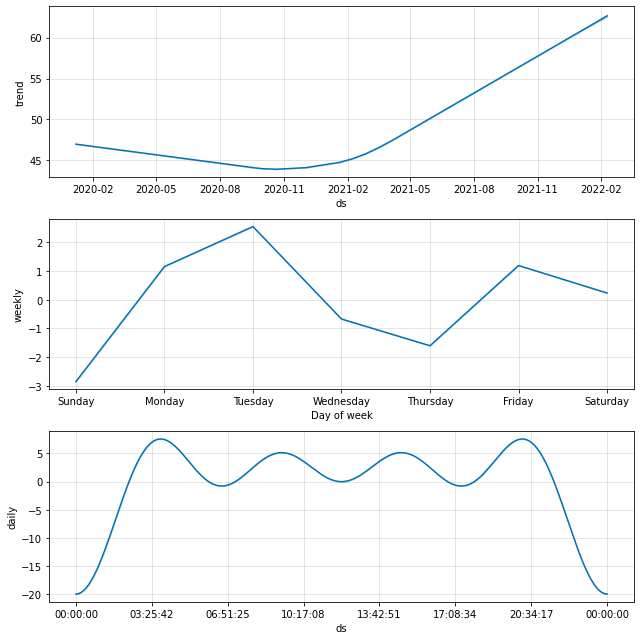

In [145]:
print('Projeto: ',proj)
m.plot_components(forecast)
plt.show()